# Strong Selection Regime

(c) 2020 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

***

In [28]:
using Revise, Plots, Polynomials, LinearAlgebra

using Jedi, Jevo


Jedi.default_gr!()

Plots.GRBackend()

## $\Gamma$ Dynamics

In [2]:
# Neutral Expectation
γ_0(n) = (n-1)/n

# Binding Threshold
γ_1(l, n, l_0) = γ_0(n) - l_0/l

# Binding probability
pb(γ, l, n, l_0, gap) = 1 / (1 + exp(gap * (l / l_0) * (γ - γ_1(l, n, l_0))))

# Fitness component for functional binding
F_b(γ, l, n, l_0, gap, f0) = f0 * pb(γ, l, n, l_0, gap)

# Fitness component of genomic constraint
F_c(l, l_0, fl) = - fl * l / l_0

# Total Fitness
F(γ, l, n, l_0, gap, f0, fl) = F_b(γ, l, n, l_0, gap, f0) + F_c(l, l_0, fl)

# Kimura - Ohta substitution probability
g(s) = s < 10^(-10) ? 1 : s/(1 - exp(-s))

# Substitution rate for trait changes
# (k, l) -> (k + 1, l)
up(γ, l, n, gap, l_0, f0, fl, κ) =  γ_0(n) * (1 - γ) * (g(F(γ + 1/l, l, n, l_0, gap, f0, fl) 
        - F(γ, l, n, l_0, gap, f0, fl)) + κ )

# (k, l) -> (k - 1, l)
um(γ, l, n, gap, l_0, f0, fl, κ) = γ * (1 - γ_0(n)) * (g(F(γ - 1/l, l, n, l_0, gap, f0, fl) 
        - F(γ, l, n, l_0, gap, f0, fl)) + κ )

# Free Fitness
function Ψ(l, n, gap, l_0, f0, fl, κ)
    # Start at neutral γ
    γ_i = floor(γ_0(n) * l) / l
    return collect(1/l:1/l:γ_i), cumsum([log(up(γ - 1/l, l,  n, gap, l_0, f0, fl, κ) / um(γ, l,  n, gap, l_0, f0, fl, κ)) for γ in 1/l:1/l:γ_i])
    
end

Ψ (generic function with 1 method)

## Parameters

In [3]:
gap = 10
l_0 = 20
lmax = 200
f0 = 20l_0
fl = .7l_0
κ = 0
n = 4


4

Let's check binding probability first to confirm the landscape definition.

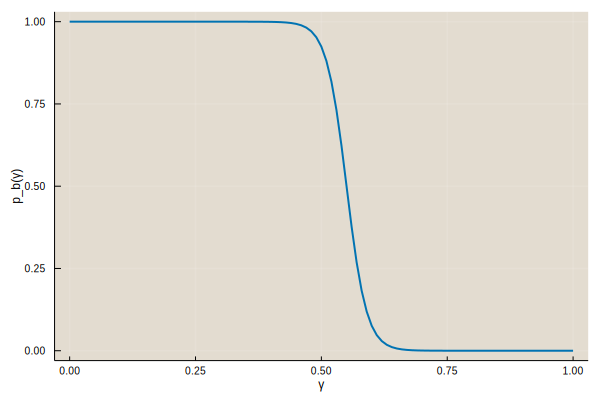

In [122]:
plot(
    0:1/100:1, 
    [pb(γ, 100, n, l_0, gap) for γ in 0:1/100:1],
    xlabel="γ",
    ylabel="p_b(γ)",
    linewidth=2
)

Looks very good.

Next, let's have look at free fitness and check if it looks appropriate.

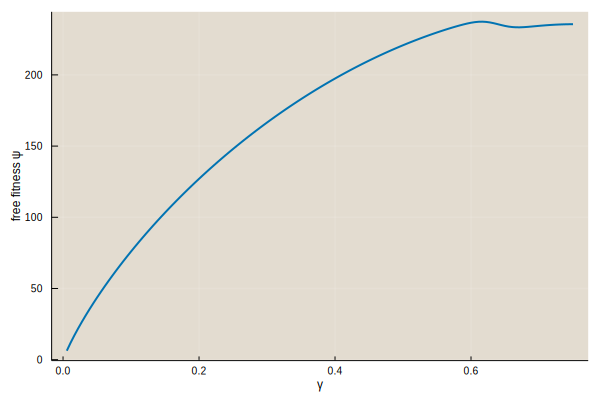

In [5]:
plot(
    Ψ(180, 4, gap, l_0, f0, fl, 20),
    xlabel="γ",
    ylabel="free fitness ψ",
    linewidth=2
)

To find the optimal intensive energy, we can interpolate the maximum with a quadratic function and compute the maximum.

In [6]:
function γ_star(l, n, gap, l_0, f0, fl, κ)
    x, y = Ψ(l, n, gap, l_0, f0, fl, κ) 
    max_ind = argmax(y)
    if max_ind == length(x)
        return x[end]
    elseif max_ind == 1
        return x[1]
    else
        f = fit(x[max_ind-1:max_ind+1], y[max_ind-1:max_ind+1], 2)
        return -f[1]/2f[2]
    end
end

γ_star (generic function with 1 method)

Let's add some extra functions to evaluate fitness and binding probability at the optimal intensive energy.

In [7]:
Fstar(l, n, gap, l_0, f0, fl, κ) = F(γ_star(l, n, gap, l_0, f0, fl, κ), l, n, l_0, gap, f0, fl)

pb_star(l, n, gap, l_0, f0, fl, κ) = pb(γ_star(l, n, gap, l_0, f0, fl, κ), l, n, l_0, gap)

s_star(l, n, gap, l_0, f0, fl, κ) = F(γ_star(l, n, gap, l_0, f0, fl, κ) + 1/l, l, n, l_0, gap, f0, fl) - 
  F(γ_star(l, n, gap, l_0, f0, fl, κ), l, n, l_0, gap, f0, fl)


s_star (generic function with 1 method)

## L dynamics

In [8]:
# length-changing mutation steps

# (k,l) -> (k+1,l+1)
γ_pp(γ, l) = min((γ + 1/l)/(1 + 1/l), 1)

# (k,l) -> (k,l+1)
γ_pm(γ, l) = max(γ /(1 + 1/l), 0)

# (k,l) -> (k,l-1)
γ_mp(γ, l) = min(γ/(1 - 1/l), 1)

# (k,l) -> (k-1,l-1)
γ_mm(γ, l) = max((γ - 1/l)/(1 - 1/l), 0)


# selection coeffcients for length increase and decrease
s_pp(γ, l, n, l_0, gap, f0, fl) = 
    F(γ_pp(γ, l), l + 1, n, l_0, gap, f0, fl) - 
    F(γ, l, n, l_0, gap, f0, fl)

s_pm(γ, l, n, l_0, gap, f0, fl) = 
    F(γ_pm(γ, l), l + 1, n, l_0, gap, f0, fl) - 
    F(γ, l, n, l_0, gap, f0, fl)

s_mm(γ, l, n, l_0, gap, f0, fl) = 
 F(γ_mm(γ, l), l - 1, n, l_0, gap, f0, fl) - 
  F(γ, l, n, l_0, gap, f0, fl) 

s_mp(γ, l, n, l_0, gap, f0, fl) = 
 F(γ_mp(γ, l), l - 1, n, l_0, gap, f0, fl) - 
  F(γ, l, n, l_0, gap, f0, fl)


# substitution rates of length increase and decrease
v_pp(γ, l, n, l_0, gap, f0, fl) = γ_0(n) * g(s_pp(γ, l, n, l_0, gap, f0, fl))

v_pm(γ, l, n, l_0, gap, f0, fl) = (1 - γ_0(n)) * g(s_pm(γ, l, n, l_0, gap, f0, fl))

v_plus(γ, l, n, l_0, gap, f0, fl) = v_pp(γ, l, n, l_0, gap, f0, fl) + v_pm(γ, l, n, l_0, gap, f0, fl)

v_plus_star(l, n, l_0, gap, f0, fl) = v_plus(γ_star(l, n, l_0, gap, f0, fl, κ), l, n, l_0, gap, f0, fl)

v_mm(γ, l, n, l_0, gap, f0, fl) = γ * g(s_mm(γ, l, n, l_0, gap, f0, fl)) 

v_mp(γ, l, n, l_0, gap, f0, fl) = (1 - γ) * g(s_mp(γ, l, n, l_0, gap, f0, fl))

v_minus(γ, l, n, l_0, gap, f0, fl) = v_mm(γ, l, n, l_0, gap, f0, fl) + v_mp(γ, l, n, l_0, gap, f0, fl) 

v_minus_star(l, n, l_0, gap, f0, fl, κ) = v_minus(γ_star(l, n, l_0, gap, f0, fl, κ), l, n, l_0, gap, f0, fl)

# Effective Fitness
F_eff(l, n, l_0, gap, f0, fl, κ) = sum([log(v_plus_star(l_, n, l_0, gap, f0, fl, κ)/
    v_minus_star(l_, n, l_0, gap, f0, fl, κ)) for l_  in l_min(n, l_0, gap):l])

# minimal length of functional sites, from condition γ_1(lmin, l_0) + l_0/(l_min * gap) = 1 
l_min(n, l_0, gap) = ceil(l_0 * (gap + 1) / ((1 - γ_0(n)) * gap)) 

l_min (generic function with 1 method)

In [9]:
γ_star_list(n, gap, l_0, f0, fl, κ, l_max=200) = [l > 10 ? γ_star(l, n, gap, l_0, f0, fl, κ) : missing  for l in 1:l_max]

function l_star(n, l_0, gap, f0, fl, κ, l_max=200) 
    gstarlist = γ_star_list(n, gap, l_0, f0, fl, κ)
    funct_pos_list = []
    for l in 1:l_max
        if (~ismissing(gstarlist[l])) && (gstarlist[l] < γ_1(l, n, l_0))
            push!(funct_pos_list, l)
        end
    end
    γ_fun_list = gstarlist[funct_pos_list]
    lm = funct_pos_list[1]
    f_list = zeros(l_max)

    f_list[lm+1:l_max] = cumsum([log(v_plus(gstarlist[i-1], i-1, n, l_0, gap, f0, fl)/
                v_minus(gstarlist[i], i, n, l_0, gap, f0, fl)) for i in lm+1:l_max])
    max_ind = argmax(f_list)
        
    fmax = f_list[max_ind]
    lst = max_ind
    return gstarlist, γ_fun_list, f_list, fmax, lst, lm
end

l_star (generic function with 2 methods)

lstar = 70
γ star = 0.361397938304482
minimal length of functional sites: 33


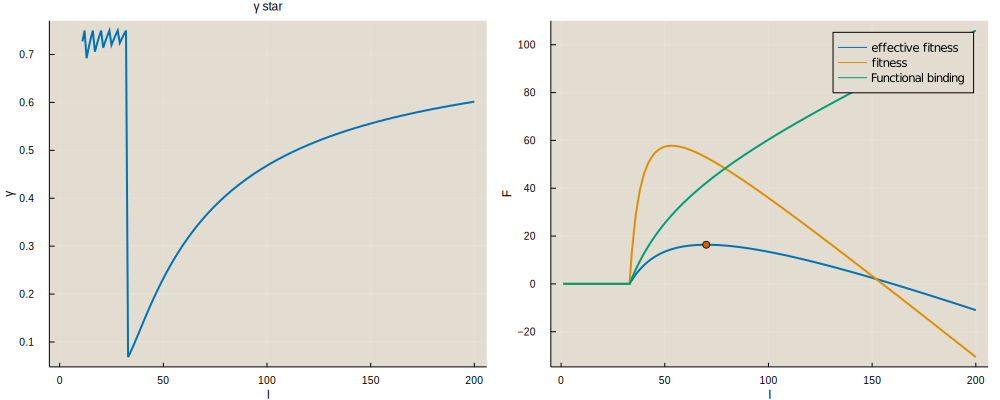

In [10]:
gstarlist, γ_fun_list, f_list, fmax, lst, lm = l_star(n, l_0, gap, f0, fl, 0)
println("lstar = ", lst)
println("γ star = ", gstarlist[lst])
println("minimal length of functional sites: ", lm)
p1 = plot(gstarlist, xlabel="l", ylabel="γ", title="γ star", linewidth=2)

    
fb = [l>lm ? f_list[l] - F_c(l, l_0, fl) + F_c(lm, l_0, fl) : 0 for l in 1:200]
f = [l>lm ? F(gstarlist[l], l, n, l_0, gap, f0, fl) - F(gstarlist[lm], lm, n, l_0, gap, f0, fl) : 0 for l in 1:200]
p2 = plot(f_list, xlabel="l", ylabel="F", label="effective fitness", linewidth=2, legend=:topright)
plot!(p2, f, linewidth=2, label="fitness")
plot!(p2, fb, linewidth=2, label="Functional binding")


scatter!(p2, [lst], [fmax])
plot([p1, p2]..., size=(1000, 400))

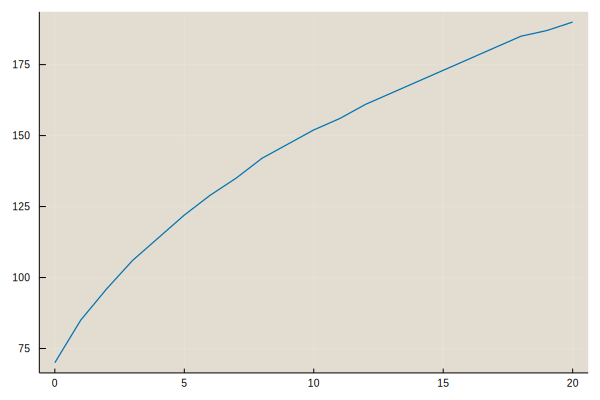

In [11]:
plot(0:1:20, [l_star(n, l_0, gap, f0, fl, κ)[5] for κ in 0:1:20])

### Numerics

In [72]:
N = 1000
steps = 10^6

1000000

In [114]:
f_num = Jevo.num_fermi(n, l_0, gap, f0/2N, fl/2N)

Jevo.num_fermi(4, 20, 10, 0.2, 0.007)

In [115]:
Jevo.fitness(0.1, 60, f_num)

0.178999176285651

In [108]:
emat = gap/l_0 * (ones(n, n) - Matrix{Float64}(I, n, n))
trace = zeros(Float64, 100)
l = 100
κ = 10
for j in 1:100
    pop = Jevo.mono_pop(N=N, l=l)
    Jevo.initiate!(pop, emat)
    for i in 1:steps
        Jevo.bp_substitution!(pop, emat, f_num)
        if rand() < κ/N
            Jevo.driver_mutation!(pop)
        end
    end
    trace[j] = Jevo.get_energy(pop, emat) *l_0/l/gap
end

In [123]:
f_plot = Jevo.fitness.((l*gap/l_0) .* (minimum(trace)-3/l:1/l:maximum(trace)+3/l), l, f_num);

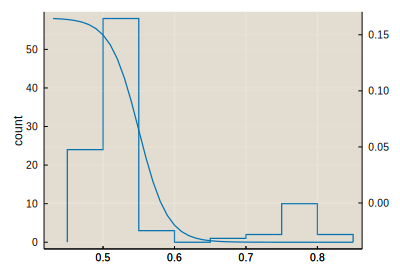

In [124]:
p = Jedi.histogram(data=trace)
plot!(twinx(), minimum(trace)-3/l:1/l:maximum(trace)+3/l, f_plot)

In [111]:
γ_star(l, n, gap, l_0, f0, fl, κ)

0.5107110876992965